In [19]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle
from importlib import reload
import h5py
from nilearn import plotting
import nibabel as nib
from sklearn.cross_decomposition import PLSRegression
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap


os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

### Important to distinguish between main Methods and large image files, a lot of these files don't need to be temporarily stored, but just easily accessible

In [50]:
class DataFetch():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    # Function to get the pRF-based voxel selections
    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.
    def prf_selections(self):
        prf_selection_paths = [
            './data/custom_files/subj01/prf_mask_center_strict.pkl',
            './data/custom_files/subj01/prf_mask_central_strict_l.pkl',
            './data/custom_files/subj01/prf_mask_central_halfloose.pkl',
            './data/custom_files/subj01/prf_mask_central_loose.pkl',
            './data/custom_files/subj01/prf_mask_periphery_strict.pkl'
        ]
        return {os.path.basename(file): self._fetch_file(file) for file in prf_selection_paths}
    
    # General file fetching function 
    def fetch_file(self, file_path:str):
        """
        General function to acquire saved data from various file types
        file_type: str, the types of files to be fetched, either features or prf_selections
        """
        _, ext = os.path.splitext(file_path)
        
        # Check if file is of .h5 type
        if ext == '.h5':
            with h5py.File(file_path, 'r') as hf:
                data = hf.keys()
                return {key: np.array(hf[key]).flatten() for key in data}
        # Check if file is of .pkl type
        elif ext == '.pkl':
            with open(file_path, 'rb') as fp:
                return pickle.load(fp)
            
            
    # Function to load in nifti (.nii.gz) data and create some useful variables 
    def get_dat(self, path:str):
        full_dat = nib.load(path)
        dat_array = full_dat.get_fdata()
        
        # Calculate the range of values
        flat_arr = dat_array[~np.isnan(dat_array)]
        dat_dim = dat_array.shape

        return full_dat, dat_array, dat_dim, {'min': round(np.nanmin(flat_arr),7), 'max': np.nanmax(flat_arr), 'mean': round(np.nanmean(flat_arr),5)}

In [51]:
class Cortex():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    
    
    

In [52]:
class Utilities():

    def __init__(self):
        pass
        
    # Utility function to visualize dictionary structures
    def print_dict_structure(self, d, indent=0):
        for key, value in d.items():
            print(' ' * indent + str(key))
            if isinstance(value, dict):
                self.print_dict_structure(value, indent + 4)
                
                
    def print_large(self, item):
        with np.printoptions(threshold=np.inf):
            print(item)
            
            
    def get_zscore(self, data, print_ars = 'y'):
        mean_value = np.mean(data)
        std_dev = np.std(data)

        # Calculate z-scores
        z_scores = (data - mean_value) / std_dev

        if print_ars == 'y':
            print("Original array:", data)
            print("Z-scores:", z_scores)
            
        return z_scores

    def cap_values(self, array = None, lower_threshold = None, upper_threshold = None):
        
        if upper_threshold is None:
            upper_threshold = np.max(array)
        else:
            # Identify values above the upper threshold
            above_upper_threshold = array > upper_threshold
            
            # Identify the highest value below the upper threshold
            highest_below_upper_threshold = array[array <= upper_threshold].max()

            # Replace values above the upper threshold with the highest value below the upper threshold
            array[above_upper_threshold] = highest_below_upper_threshold

        if lower_threshold is None:
            lower_threshold = np.min(array)
        else:
            # Identify values below the lower threshold
            below_lower_threshold = array < lower_threshold

            # Identify the lowest value above the lower threshold
            lowest_above_lower_threshold = array[array >= lower_threshold].min()

            # Replace values below the lower threshold with the lowest value above the lower threshold
            array[below_lower_threshold] = lowest_above_lower_threshold

        return array

    def mean_center(self, data, print_ars = 'y'):
        mean_value = np.mean(data)

        # Mean centering
        centered_data = data - mean_value

        if print_ars == 'y':
            print("Original array:", data)
            print("Centered data:", centered_data)
            
        return centered_data
    
    def multiple_regression(self, X, y):
        # Add a column of ones to the end of the X matrix
        X = np.hstack((X, np.ones((X.shape[0], 1))))

        # Calculate the coefficients
        beta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

        return beta

    # Function to generate a bell-shaped vector
    def generate_bell_vector(self, n, width, location, kurtosis=0, plot = 'y'):
        x = np.linspace(0, 1, n)
        y = np.exp(-0.5 * ((x - location) / width) ** 2)
        
        if kurtosis != 0:
            y = y ** kurtosis
        
        y /= np.sum(y)  # Normalize the vector to sum up to 1
        
        if plot == 'y':
            plt.scatter(x, y)
            plt.xlabel('Index')
            plt.ylabel('Value')
            plt.title('Bell-Shaped Vector')
            plt.show()
            
        return y

    # Function to plot the hypotheses for the feature and unpredictability sensitivity
    def hypotheses_plot(self):

        hypothesis_1 = hypothesis_2 = np.zeros((4, 5))
        for i in range(4):
            loc = i/3
            # generate_bell_vector(5, 0.15, loc)
            hypothesis_1[i, :] = np.array(self.generate_bell_vector(5, 0.0115, loc, 0.01, plot = 'n'))
            
        hypothesis_3 = np.zeros((4, 5))
        for i in range(4):
            loc = i/3
            # generate_bell_vector(5, 0.15, loc)
            hypothesis_3[np.abs(i - 3), :] = np.array(self.generate_bell_vector(5, 0.0115, loc, 0.01, plot = 'n'))
            
        # Keeping the same values for Hypothesis 4
        hypothesis_4 = np.zeros((4, 5))
        for i in range(4):
            hypothesis_4[i, :] = hypothesis_1[3]

        hypotheses = [hypothesis_1, hypothesis_2, hypothesis_3, hypothesis_4]

        # Visual areas
        visual_areas = ['V1', 'V2', 'V3', 'V4']

        # Define a gradient colormap from dark blue to light red
        cmap = LinearSegmentedColormap.from_list('NavyBlueVeryLightGreyDarkRed', ['#000080', '#CCCCCC', '#FFA500', '#FF0000'], N=5)

        # Plotting
        fig, axs = plt.subplots(1, 4, figsize=(np.array([14, 4.25])*1.1), sharey=True)
            
        plt.subplots_adjust(wspace=-1)  # Adjust this value to your liking

        for i, hypothesis in enumerate(hypotheses):
            ax = axs[i]
            # Transpose the hypothesis so that each vector becomes a column
            hypothesis_t = np.transpose(hypothesis)
            bottom = np.zeros(len(hypothesis_t[0]))
            for j, data in enumerate(hypothesis_t):
                ax.bar(range(len(data)), data, bottom=bottom, edgecolor='none', linewidth=0.5, label=f'{j+1}', color=cmap(j))
                bottom += data
            ax.set_title(['Visual feature sensitivity\n\n\n', 
                        'Hypothesis 1: \nTraditionally hierarchical\nunpredictability sensitivity\n', 
                        'Hypothesis 2: \nReversed hierarchical\nunpredictability sensitivity\n', 
                        'Hypothesis 3: \nNon-hierarchical\nunpredictability sensitivity\n'][i], 
                        fontweight='normal', family = 'sans-serif', fontsize = 16)
            ax.set_ylim(0, 1)  # Adjust the y-axis limits based on your data range
            ax.set_yticks([0, 0.5, 1])  # Set y-ticks
            ax.set_yticklabels([0, 50, 100])  # Change y-tick labels
            ax.spines['top'].set_visible(False)  # Remove top border
            ax.spines['right'].set_visible(False)  # Remove right border
            ax.set_xticks(range(len(visual_areas)))  # Set x-ticks
            ax.set_xticklabels(visual_areas)  # Set x-tick labels
            ax.grid(False)  # Remove grid

        # Remove 'Category' label from the bottom
        fig.text(0.5, 0, '', ha='center', va='center', fontsize=14)
        fig.text(0.0, 0.43, 'Layer Assignment (%)', va='center', rotation='vertical', fontweight='normal', fontsize = 15)
        fig.text(0.105, -.01, 'Visual Areas', ha='left', fontweight='normal', fontsize = 15)

        axs[0].legend(title='CNN Layer', loc = 'upper center', bbox_to_anchor=(0.5, 1.27),
                ncol=5, fancybox=False, shadow=False, fontsize = 11.5, columnspacing = .55)

        plt.tight_layout()
        plt.show()
        
    def numpy2coords(self, boolean_array, keep_vals:bool = False):
        # Get the coordinates of the True values in the boolean array
        coordinates = np.array(np.where(boolean_array))
        
        if keep_vals:
            # Get the values at the coordinates
            values = boolean_array[coordinates[0], coordinates[1], coordinates[2]]
            
            # Add the values as a fourth row to the coordinates
            coordinates = np.vstack([coordinates, values])
        
        # Transpose the coordinates to get them in the correct shape
        coordinates = coordinates.T
        
        return coordinates

    def coords2numpy(self, coordinates, shape, keep_vals:bool = False):
        # Create an array with the same shape as the original array
        array = np.zeros(shape, dtype=float if keep_vals else bool)
        
        if keep_vals:
            # Set the cells at the coordinates to their corresponding values
            array[tuple(coordinates[:,:3].astype('int').T)] = coordinates[:,3]
        else:
            # Set the cells at the coordinates to True
            # if coordinates
            # array[tuple(coordinates.T)] = True
                array[tuple(coordinates[:,:3].astype('int').T)] = True
        
        return array

    def find_common_rows(self, values_array, mask_array, keep_vals:bool = False):
        cols_vals = values_array.shape[1] - 1
        cols_mask = mask_array.shape[1] - 1
        set1 = {tuple(row[:cols_vals]): row[cols_vals] for row in values_array}
        set2 = set(map(tuple, mask_array[:,:cols_mask]))
        
        common_rows = np.array([list(x) + ([set1[x]] if keep_vals else []) for x in set1.keys() & set2])
        return common_rows    

    def sort_by_column(self, array, column_index, top_n):
        # Get the column
        column = array[:, column_index]

        # Get the indices that would sort the column
        sorted_indices = np.argsort(column)

        # Reverse the indices to sort in descending order and get the top_n indices
        top_indices = sorted_indices[::-1][:top_n]

        # Sort the entire array by these indices
        sorted_array = array[top_indices]

        return sorted_array

    # Function to return the voxel coordinates based on the parameter represented in the 4th column
    def filter_array_by_size(self, array, size_min, size_max):
        filtered_array = array[(array[:, 3] >= size_min) & (array[:, 3] <= size_max)]
        return filtered_array

    def ecc_angle_to_coords(self, ecc, angle, dim = 425):
        
        y = ((1 + dim) / 2) - (ecc * np.sin(np.radians(angle)) * (dim / 8.4)) #y in pix (c_index)
        x = ((1 + dim) / 2) + (ecc * np.cos(np.radians(angle)) * (dim / 8.4)) #x in pix (r_index)
        
        x = ecc * np.cos(np.radians(angle))
        y = ecc * np.sin(np.radians(angle))
        return x, y


    def voxname_for_xyz(self, xyz_to_voxname:np.array, x:int, y:int, z:int):
        # Create a boolean mask that is True for rows where the first three columns match val1, val2, val3
        mask = (xyz_to_voxname[:, 0] == x) & (xyz_to_voxname[:, 1] == y) & (xyz_to_voxname[:, 2] == z)

        # Use the mask to select the matching row(s) and the fourth column
        voxname = xyz_to_voxname[mask, 3]

        # If there is only one matching row, voxname will be a one-element array
        # You can get the element itself with:
        if voxname.size == 1:
            voxname = voxname[0]

        return voxname
    
    # Function to create a list solely containing roi-based voxels
    def roi_filter(self, roi_mask, input_array, nan2null:bool=False):
        roi_ices = np.argwhere(roi_mask != 0)

        # Create list that only contains the voxels of the specific roi
        roi_ar = np.column_stack((roi_ices, input_array[roi_ices[:, 0], roi_ices[:, 1], roi_ices[:, 2]]))

        # Turn the nan values into zeros for the angle parameter
        if nan2null:
            output_roi = np.nan_to_num(roi_ar, nan=0)
            
        # Filter away the nan values
        output_roi = roi_ar[~np.isnan(roi_ar).any(axis=1)]
        rounded_output_roi = np.round(roi_ar, 5)
        
        # Set print options to control precision and suppress scientific notation
        np.set_printoptions(precision=5, suppress=True)
        
        return rounded_output_roi
        

In [64]:
class VisualInput():
    
    def __init__(self, NSPobject):
        self.nsp = NSPobject
        pass
    
    # Function to show a randomly selected image of the nsd dataset
    def show_stim(self, img_no='random', small:bool=False, hide:bool=False):
        # Example code to show how to access the image files, these are all 73000 of them, as np.arrays
        # I keep it like this as it might be useful to also store the reconstructed images with the autoencoder
        # using a .hdf5 folder structure, but I can change this later on.

        stim_dir = '/home/rfpred/data/natural-scenes-dataset/nsddata_stimuli/stimuli/nsd/'
        stim_files = os.listdir(stim_dir)

        with h5py.File(f'{stim_dir}{stim_files[0]}', 'r') as file:
            img_brick_dataset = file['imgBrick']
            
            if img_no == 'random':
                image_no = random.randint(0,img_brick_dataset.shape[0])
            else: image_no = img_no
            
            test_image = img_brick_dataset[image_no]
        hor = ver = 10
        if small:
            hor = ver = 5        
        if hide is not True:
            plt.figure(figsize=(hor, ver))
            plt.imshow(test_image)
            plt.title(f'Image number {image_no}')
            plt.axis('off')
            plt.show()
            
        return test_image, image_no
    
    # Function to get the visual contrast features and predictability estimates
    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.
    def features(self):
        feature_paths = [
            './data/custom_files/all_visfeats_rms.pkl',
            './data/custom_files/all_visfeats_rms_crop_prior.pkl',
            '/home/rfpred/data/custom_files/all_visfeats_scce.pkl',
            '/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl',
            '/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5'
        ]
        return {os.path.basename(file): self.nsp.datafetch.fetch_file(file) for file in feature_paths}
    
    
    # Create design matrix containing ordered indices of stimulus presentation per subject
    def get_imgs_designmx(self):
        
        subjects = os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata')
        exp_design = '/home/rfpred/data/natural-scenes-dataset/nsddata/experiments/nsd/nsd_expdesign.mat'
        
        # Load MATLAB file
        mat_data = loadmat(exp_design)

        # Order of the presented 30000 stimuli, first 1000 are shared between subjects, rest is randomized (1, 30000)
        # The values take on values betweeon 0 and 1000
        img_order = mat_data['masterordering']-1

        # The sequence of indices from the img_order list in which the images were presented to each subject (8, 10000)
        # The first 1000 are identical, the other 9000 are randomly selected from the 73k image set. 
        img_index_seq = (mat_data['subjectim'] - 1) # Change from matlab to python's 0-indexing
        
        # Create design matrix for the subject-specific stimulus presentation order
        stims_design_mx = {}
        stim_list = np.zeros((img_order.shape[1]))
        for n_sub, subject in enumerate(sorted(subjects)):
        
            for stim in range(0, img_order.shape[1]):
                
                idx = img_order[0,stim]
                stim_list[stim] = img_index_seq[n_sub, idx]
                
            stims_design_mx[subject] = stim_list.astype(int)
        
        return stims_design_mx

In [65]:
class NatSpatPred():
    
    def __init__(self, datapath:str='/home/rfpred/data'):
        # Define the subclasses
        self.utils = None
        self.cortex = None
        self.visualinput = None
        self.datafetch = None
        self.analyse = None
        
        self.datapath = datapath
        self.subjects = sorted(os.listdir(f'{datapath}/natural-scenes-dataset/nsddata/ppdata'), key=lambda s: int(s.split('subj')[-1]))
        self.attributes = None
        self.hidden_methods = None


    # TODO: Expand this initialise in such way that it creates all the globally relevant attributes by calling on methods from the
    # nested classes
    def initialise(self):
        self.utils = Utilities()
        self.cortex = Cortex(self)
        self.visualinput = VisualInput(self)
        self.datafetch = DataFetch(self)
        
        # self.ois, self.oi_masks = self.make_visrois_dict() # All these immediate ones can be called directly
        # self.rf_dict = self.write_prf_dict()
        # self.eats = self.atafetch.features()
        # self.rfloc_vox_selections = self.atafetch.prf_selections()
        
        self.attributes = [attr for attr in dir(self) if not attr.startswith('_')] # Filter out both the 'dunder' and hidden methods
        self.attributes_unfiltered = [attr for attr in dir(self) if not attr.startswith('__')] # Filter out only the 'dunder' methods
        
        print(f'Naturalistic Spatial Prediction class: {Fore.LIGHTGREEN_EX}Initialised{Style.RESET_ALL}')
        print('\nClass contains the following attributes:')
        for attr in self.attributes:
            print(f"{Fore.LIGHTWHITE_EX}\t.{attr}{Style.RESET_ALL}")


    def visrois_dict(self, verbose:bool=False):
        rois = []
        binary_masks = {}

        for subj_no in range(1, len(self.ubjects) + 1):
            if verbose:
                print(f'Fetching roi masks for subject {Fore.LIGHTBLUE_EX}{subj_no}{Style.RESET_ALL}')
            mask_dir = f'{self.datapath}/natural-scenes-dataset/nsddata/ppdata/subj0{subj_no}/func1mm/roi'

            # read in and sort all the filenames in the mapped masks folder for each subject
            non_binary_masks = sorted([file for file in os.listdir(mask_dir) if '_mask.nii' in file])
            subj_binary_masks = {}

            for idx, mask_file in enumerate(non_binary_masks):
                # Load the mask file
                subj_binary_masks[non_binary_masks[idx][:-7]] = (nib.load(os.path.join(mask_dir, mask_file)).get_fdata()).astype(int)
            if verbose:
                # Print the amount of non-zero voxels in the roi
                for key, subj_binary_mask in subj_binary_masks.items():
                    print(f" - Voxels in {Fore.BLUE}{key[:2]}{Style.RESET_ALL}: {np.sum(subj_binary_mask)}")
                    
            binary_masks[f'subj0{subj_no}'] = subj_binary_masks
            rois = [roi[:2] for roi in binary_masks['subj01'].keys()]
        return rois, binary_masks
    


    
    # This function provides a dictionary with all the pRF data for all subjects and rois
    def prf_dict(self, rois:list, roi_masks:dict):
        prf_dict = {}

        # Make a loop to go over all the subjects
        for subject in self.subjects:
            prf_dict[subject] = {}
            prf_dict[subject]['nsd_dat'] = {}
            
            # Initialize dictionaries if they don't exist
            prf_dict[subject]['proc'] = {}

            # Get the overall prf results, save them in a dict
            prf_types = ['angle', 'eccentricity', 'exponent', 'gain', 'meanvol', 'R2', 'size']

            for prf_type in prf_types:
                prf_path = f'{self.datapath}/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/prf_{prf_type}.nii.gz'
                prf_dat, prf_ar, prf_dim, prf_range = self.datafetch.get_dat(prf_path)
                prf_dict[subject]['nsd_dat'][prf_type] = {
                    'prf_dat': prf_dat,
                    'prf_ar': prf_ar,
                    'prf_dim': prf_dim,
                    'prf_range': prf_range
                }
            roi_list =  [f'{roistr}_mask' for roistr in rois]
            for roi in roi_list:
                prf_dict[subject]['proc'][roi] = {
                    prf_type : None for prf_type in prf_types
                } 
                for prf_type in prf_types:
                    prf_dict[subject]['proc'][roi][prf_type] = self.utils.roi_filter(roi_masks[subject][roi], prf_dict[subject]['nsd_dat'][prf_type]['prf_ar'])

            # Calculate the linear pRF sigma values, these tend to be smaller and don't take
            # into account the nonlinear relationship between input and neural respons
                lin_sigmas = prf_dict[subject]['proc'][roi]['size'][:,3] * np.sqrt(prf_dict[subject]['proc'][roi]['exponent'][:,3])
                prf_dict[subject]['proc'][roi]['lin_sigma'] = np.column_stack([prf_dict[subject]['proc'][roi]['size'][:,0:3], lin_sigmas])

        return prf_dict
    
    def anat_templates(self, prf_dict:dict):
        # Get subject-specific T1 anatomical maps to use as base for later overlays
        anat_temps = {}
        for subject in prf_dict.keys():
            anat_temps[subject] = nib.load(f'{self.datapath}/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/T1_to_func1mm.nii.gz')
        return anat_temps
    


In [66]:
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
	.analyse
	.anat_templates
	.attributes
	.cortex
	.datafetch
	.datapath
	.hidden_methods
	.initialise
	.prf_dict
	.subjects
	.utils
	.visrois_dict
	.visualinput


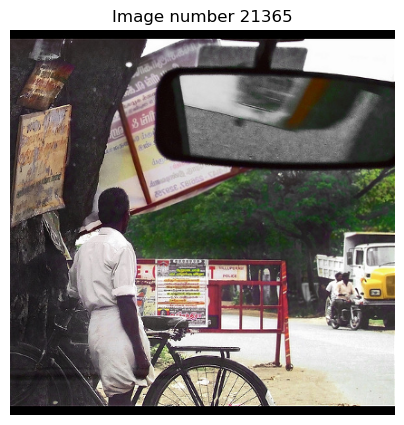

In [83]:
sok = NSP.visualinput.show_stim(img_no='random', small=True, hide=False)

In [35]:
# rois, roi_masks = NSP.visrois_dict()
# prf_dict = NSP.prf_dict(rois, roi_masks)

anats = NSP.anat_templates(prf_dict)

In [37]:
del rois, roi_masks, prf_dict, anats

In [41]:
import psutil
import os
# del NSP
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2} MB")

print_memory_usage()

Memory usage: 3874.3359375 MB


In [11]:
def print_user_variables():
    print("\n".join("%s: %s" % item for item in globals().items() if not item[0].startswith("__")))

print_user_variables()

_ih: ['', 'class DataFetch():\n    \n    def __init__(self):\n        pass\n    # Function to get the visual contrast features and predictability estimates\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def features(self):\n        feature_paths = [\n            \'./data/custom_files/all_visfeats_rms.pkl\',\n            \'./data/custom_files/all_visfeats_rms_crop_prior.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl\',\n            \'/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5\'\n        ]\n        return {os.path.basename(file): self._fetch_file(file) for file in feature_paths}\n    # Function to get the pRF-based voxel selections\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def prf_selections(self):\n        prf_selection_paths = [\n    

In [42]:
import psutil
import os

def print_cpu_usage():
    process = psutil.Process(os.getpid())
    print(f"CPU usage: {process.cpu_percent()}%")

print_cpu_usage()

CPU usage: 0.0%


In [44]:
import sys

x = "Hello, world!"
print(f"Memory usage of x: {sys.getsizeof(NSP)} bytes")

Memory usage of x: 56 bytes


In [ ]:
torch.cuda.empty_cace()

In [ ]:
# AlexNet(
#   (features): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#     (1): ReLU(inplace=True)
#     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (4): ReLU(inplace=True)
#     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (7): ReLU(inplace=True)
#     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (9): ReLU(inplace=True)
#     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (11): ReLU(inplace=True)
#     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)
#   )
# )